In [1]:
# Using Framingham
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas_profiling
%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\us61565\Desktop\Explainability\Framingham\framingham.csv')

In [ ]:
df.head()

In [ ]:
# looking at stats
pandas_profiling.ProfileReport(df)

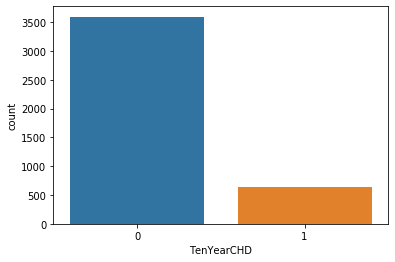

In [3]:
# Exploring the target variable
df['TenYearCHD'].value_counts(normalize = True)
sns.countplot(x='TenYearCHD',data=df)

0

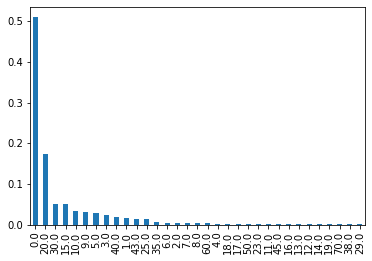

In [4]:
# Exploring cigsPerDay
df['cigsPerDay'].value_counts(normalize = True).plot(kind="bar")
df['cigsPerDay'][df['currentSmoker']==0].isna().sum()

In [5]:
# creating a boolean array of smokers
smoke = (df['currentSmoker']==1)
# applying mean to NaNs in cigsPerDay but using a set of smokers only
df.loc[smoke,'cigsPerDay'] = df.loc[smoke,'cigsPerDay'].fillna(df.loc[smoke,'cigsPerDay'].mean())
df['cigsPerDay'][df['currentSmoker']==1].mean()

18.35624394966117

In [12]:
# Filling out missing values
df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['BMI'].fillna(df.BMI.mean(), inplace = True)
df['heartRate'].fillna(df.heartRate.mean(), inplace = True)

In [14]:
df.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

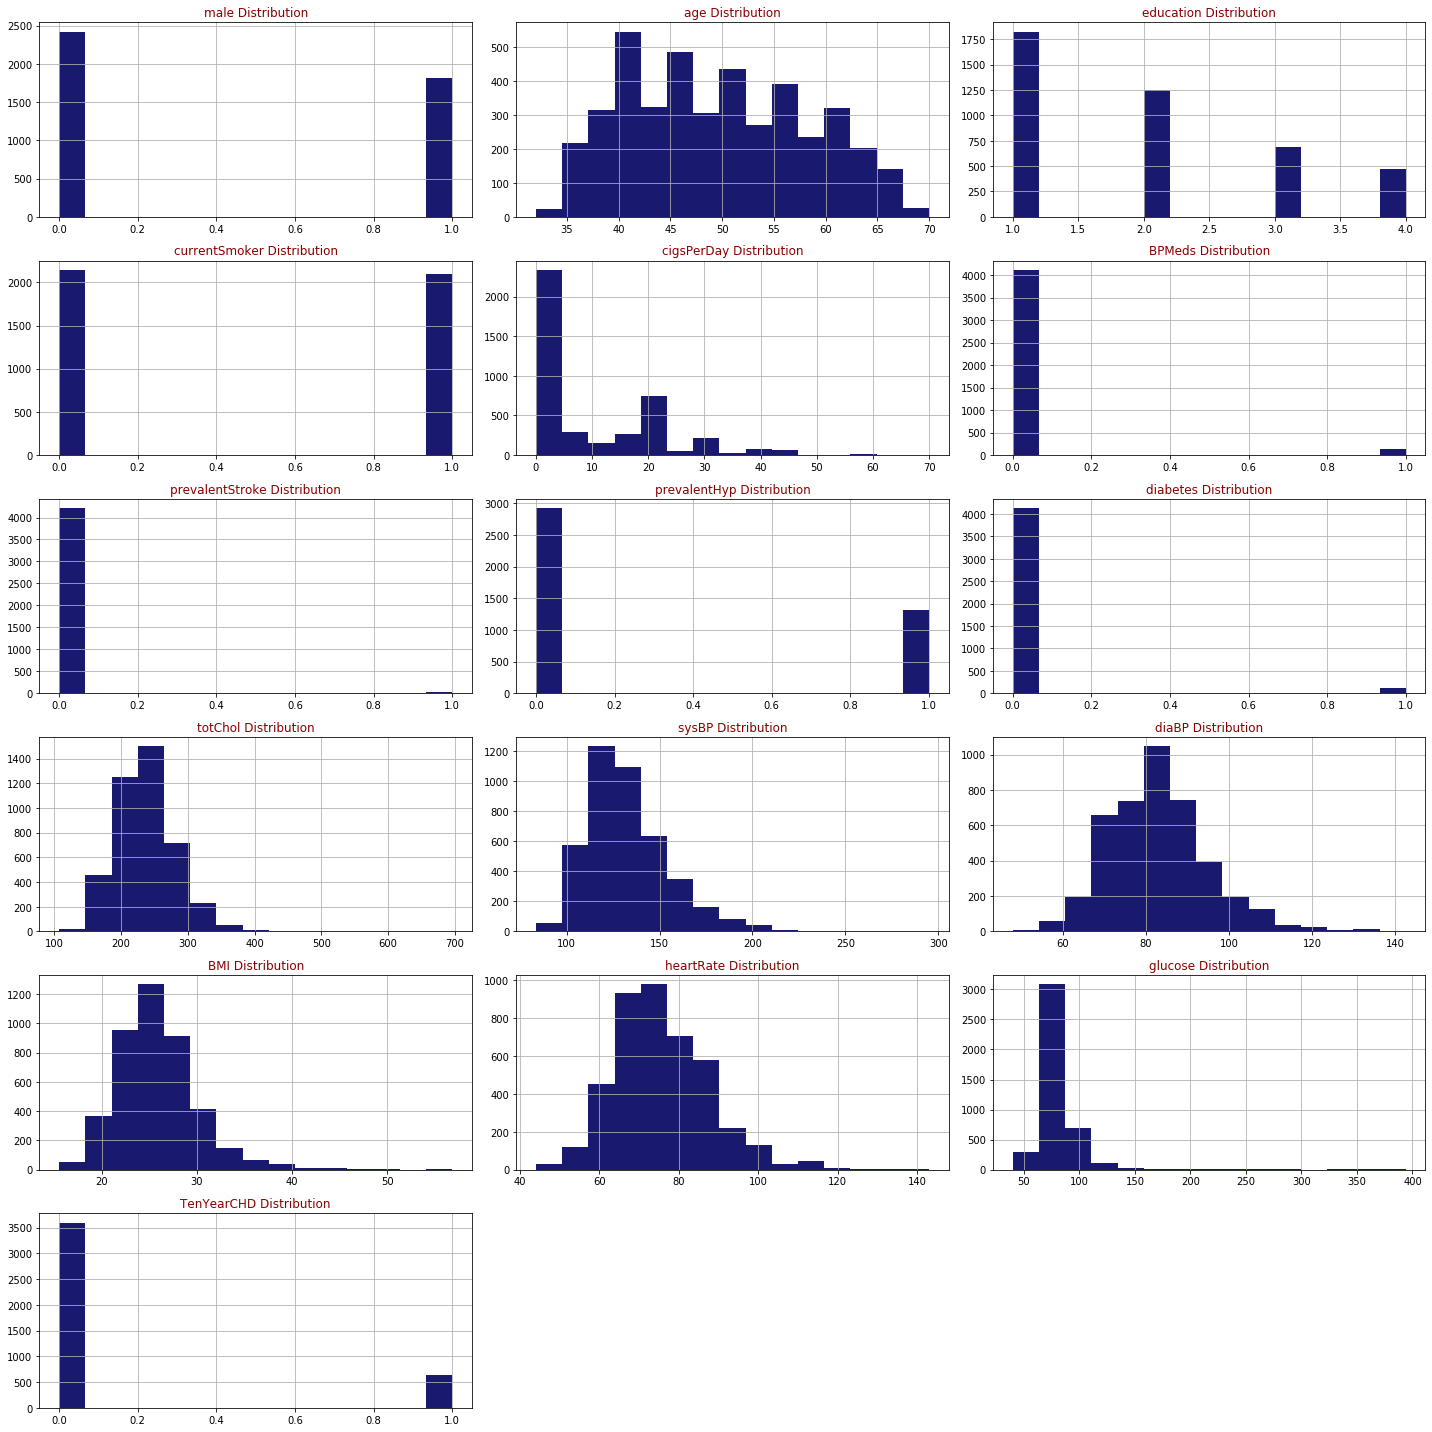

In [15]:
# A nice thing to have in front of the eyes: all histograms together
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=15,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.columns,6,3)

### A quick baseline

In [16]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [17]:
features = df.iloc[:,:-1]
result = df.iloc[:,-1]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 14)

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

([<matplotlib.axis.XTick at 0x643fb00>,
 <a list of 15 Text xticklabel objects>)

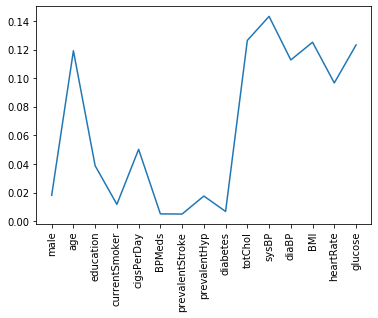

In [20]:
# what features are the most important?
plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X_train.shape[1]), X_train.columns.tolist(), rotation=90)

In [22]:
# Making predictions on unseen data
predictions_rf = rf.predict(X_test)

In [23]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       724
           1       0.30      0.02      0.04       124

    accuracy                           0.85       848
   macro avg       0.58      0.51      0.48       848
weighted avg       0.77      0.85      0.79       848



In [24]:
print(confusion_matrix(y_test, predictions_rf))

[[717   7]
 [121   3]]


In [25]:
accuracy_score(y_test, predictions_rf)

0.8490566037735849

In [27]:
# Under ROC curve
prob_rf = rf.predict_proba(X_test)
prob_rf = [p[1] for p in prob_rf]
print(roc_auc_score(y_test, prob_rf))

0.6379878809481375


### Plain vanilla log regression

In [ ]:
features = df.iloc[:,:-1]
result = df.iloc[:,-1]

In [36]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 14)

In [38]:
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train, y_train)
predictions_y_1 = logmodel.predict(X_test)

In [39]:
print(classification_report(y_test, predictions_y_1))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       724
           1       0.50      0.03      0.06       124

    accuracy                           0.85       848
   macro avg       0.68      0.51      0.49       848
weighted avg       0.80      0.85      0.79       848



In [40]:
print(confusion_matrix(y_test, predictions_y_1))

[[720   4]
 [120   4]]


In [41]:
accuracy_score(y_test, predictions_y_1)

0.8537735849056604

In [42]:
# Under ROC curve
prob_y_1 = logmodel.predict_proba(X_test)
prob_y_1 = [p[1] for p in prob_y_1]
print(roc_auc_score(y_test, prob_y_1))

0.7493650864373551


In [34]:
# View a list of the features and their importance scores
list(zip(features, rf.feature_importances_))

[('male', 0.018142704000651516),
 ('age', 0.11912912003080449),
 ('education', 0.0387808604183119),
 ('currentSmoker', 0.011843868813381366),
 ('cigsPerDay', 0.05025502915713104),
 ('BPMeds', 0.005156869543508809),
 ('prevalentStroke', 0.005044178700672876),
 ('prevalentHyp', 0.017620118958566557),
 ('diabetes', 0.006848132427562685),
 ('totChol', 0.12636760016141296),
 ('sysBP', 0.14317505086369062),
 ('diaBP', 0.11271845245919798),
 ('BMI', 0.12509086163763694),
 ('heartRate', 0.09665417464003491),
 ('glucose', 0.12317297818743542)]

### Same but normalizing features

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [45]:
logmodel.fit(X_train_std, y_train)
predictions_y_2 = logmodel.predict(X_test_std)

In [46]:
print(classification_report(y_test, predictions_y_2))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       724
           1       0.40      0.05      0.09       124

    accuracy                           0.85       848
   macro avg       0.63      0.52      0.50       848
weighted avg       0.79      0.85      0.80       848



In [47]:
print(confusion_matrix(y_test, predictions_y_2))

[[715   9]
 [118   6]]


In [48]:
accuracy_score(y_test, predictions_y_2)

0.8502358490566038

In [49]:
# Under ROC curve
prob_y_2 = logmodel.predict_proba(X_test_std)
prob_y_2 = [p[1] for p in prob_y_2]
print(roc_auc_score(y_test, prob_y_2))

0.7551015861700232


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_jobs=2, n_estimators=10000, random_state=0)
clf.fit(X_train_std, y_train)
predictions_y_3 = clf.predict(X_test_std)

In [ ]:
print(classification_report(y_test, predictions_y_3))

In [ ]:
print(confusion_matrix(y_test, predictions_y_3))

In [ ]:
accuracy_score(y_test, predictions_y_3)

In [ ]:
# Under ROC curve
prob_y_3 = clf.predict_proba(X_test_std)
prob_y_3 = [p[1] for p in prob_y_3]
print(roc_auc_score(y_test, prob_y_3))

In [ ]:
# View a list of the features and their importance scores
list(zip(features, clf.feature_importances_))

### Feature selection using Random Forest

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.12
sfm = SelectFromModel(clf, threshold=0.12)

# Train the selector
sfm.fit(X_train_std, y_train)

In [ ]:
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train_std.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_std.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_std.shape[1]), indices)
plt.xlim([-1, X_train_std.shape[1]])
plt.show()

In [ ]:
# with only imporant features - there are five of them. Can check X_important_train.shape[1]
X_important_train = sfm.transform(X_train_std)
X_important_test = sfm.transform(X_test_std)

In [ ]:
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)

In [ ]:
predictions_y_4 = clf_important.predict(X_important_test)

In [ ]:
print(classification_report(y_test, predictions_y_4))

In [ ]:
print(confusion_matrix(y_test, predictions_y_4))

In [ ]:
accuracy_score(y_test, predictions_y_4)

In [ ]:
# Under ROC curve
prob_y_4 = clf_important.predict_proba(X_important_test)
prob_y_4 = [p[1] for p in prob_y_4]
print(roc_auc_score(y_test, prob_y_4))

In [ ]:
# View a list of the features and their importance scores
list(zip(features, clf_important.feature_importances_))

### With XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import graphviz

In [ ]:
data_dmatrix = xgb.DMatrix(data=X_train_std,label=y_train)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.08,
                max_depth = 7, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train_std,y_train)
prediction_y_5 = xg_reg.predict(X_test_std)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, prediction_y_5))
print("RMSE: %f" % (rmse))

In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [ ]:
cv_results.head()

In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [ ]:
# xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()